# Link Prediction in Biotic Interaction Networks

Link prediction in biotic interaction networks refers to predicting new or missing interactions between species, often based on their characteristics or observed relationships. Such predictions can have significant ecological implications, such as understanding species interactions, habitat connectivity, and the impact of environmental changes.

In real-time biotic interaction networks, link prediction differs significantly from traditional methods due to the dynamic nature of data collection and processing. While traditional approaches rely on static datasets collected through field surveys or historical records, real-time prediction involves continuous data streaming from live sensors, satellite imagery, camera traps, and bioacoustic devices. These real-time data sources, such as remote sensing or environmental monitoring, enable immediate updates to the network, reflecting ongoing changes in species interactions. This constant influx of information demands efficient integration, processing, and prediction pipelines that can adapt to evolving ecological conditions, making real-time link prediction more complex but also more responsive to ecological shifts

This is a very small scale example of how to approach the task of predicting interaction given a particular ecological network.





In [ ]:
import numpy as np
import pandas as pd
import networkx as nx

import requests
from io import StringIO

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler

import matplotlib.pyplot as plt

Accuracy: 0.994433457848092

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13580
           1       0.43      0.12      0.19        73

    accuracy                           0.99     13653
   macro avg       0.71      0.56      0.59     13653
weighted avg       0.99      0.99      0.99     13653



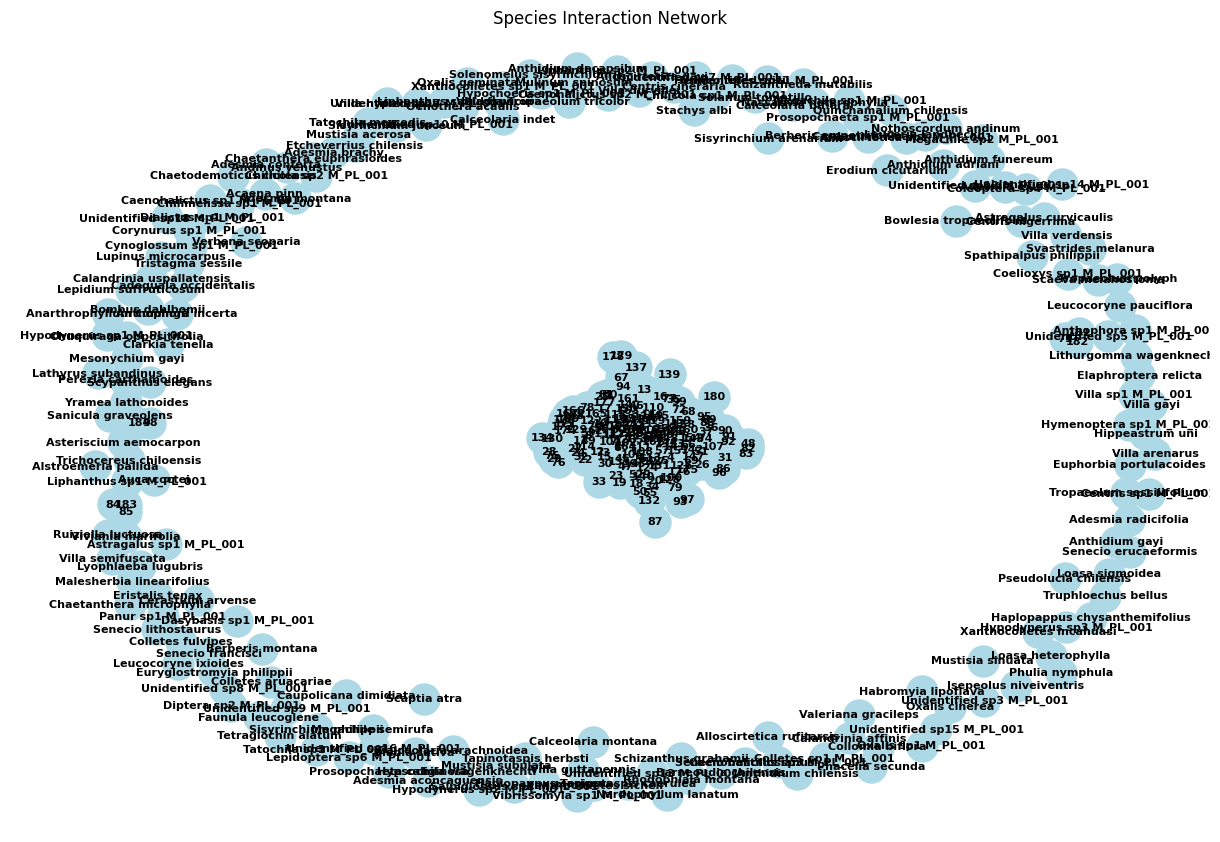


Prediction for new interaction: No interaction


In [57]:
def load_data():
    url = "https://www.web-of-life.es/networkjson.php?id=M_PL_001"
    response = requests.get(url)
    data = response.json()
    # Extract species names and interaction matrix
    species_names = data['nodes']
    interaction_matrix = data['links']

    # Convert to a more usable format if needed
    species_list = [species['name'] for species in species_names]

    # Assuming 'links' contains 'source', 'target', and 'value' for interactions
    interactions = [(link['source'], link['target']) for link in interaction_matrix]

    return species_list, interactions

def prepare_data(species_list, interactions):
    # Create a graph
    G = nx.Graph()

    # Add nodes to the graph
    G.add_nodes_from(species_list)

    # Add edges to the graph with weights (interaction values)
    for source, target in interactions:
        G.add_edge(source, target)


    # Create feature matrix and labels
    edges = list(G.edges())
    non_edges = list(nx.non_edges(G))

    # Combine edges and non-edges
    all_edges = edges + non_edges

    # Create labels (1 for existing edges, 0 for non-edges)
    labels = [1] * len(edges) + [0] * len(non_edges)

    return G, all_edges, labels

def extract_features(G, all_edges):
    features = []
    for edge in all_edges:
        node1, node2 = edge

        # Common neighbors
        common_neighbors = len(list(nx.common_neighbors(G, node1, node2)))

        # Jaccard coefficient
        jaccard = nx.jaccard_coefficient(G, [(node1, node2)])
        jaccard_coef = list(jaccard)[0][2]

        # Preferential attachment
        pa = nx.preferential_attachment(G, [(node1, node2)])
        pa_score = list(pa)[0][2]

        features.append([common_neighbors, jaccard_coef, pa_score])

    return np.array(features)

def train_and_evaluate(features, labels):
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return clf

def visualize_network(G):
    pos = nx.spring_layout(G)
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, node_color='lightblue',
            node_size=500, font_size=8, font_weight='bold')
    plt.title("Species Interaction Network")
    plt.show()

if __name__ == "__main__":
    # Load data
    species, interactions = load_data()

    # Prepare data
    G, all_edges, labels = prepare_data(species, interactions)

    # Extract features
    features = extract_features(G, all_edges)

    # Train and evaluate the model
    model = train_and_evaluate(features, labels)

    # Visualize the network
    visualize_network(G)

    # Example: Predict a new interaction
    new_interaction = np.array([[2, 0.1, 10]])  # Example features
    prediction = model.predict(new_interaction)
    print(f"\nPrediction for new interaction: {'Interaction' if prediction[0] == 1 else 'No interaction'}")

Let us experiment with the entire network

In [21]:
url = "https://www.web-of-life.es/get_networks.php"
response = requests.get(url)
data = response.json()

# Organize data by network_name
network_data = {}
for entry in data:
    network = entry['network_name']
    if network not in network_data:
        network_data[network] = []
    network_data[network].append(entry)

def create_graph_from_data(data):
    G = nx.Graph()
    for entry in data:
        source = entry['species1']
        target = entry['species2']
        strength = float(entry['connection_strength'])
        G.add_edge(source, target, weight=strength)
    return G

# Create a dictionary of graphs for each network
network_graphs = {network: create_graph_from_data(entries) for network, entries in network_data.items()}


In [51]:
import networkx as nx
import numpy as np

def extract_features_and_labels(G):
    features = []
    labels = []

    for u, v in nx.non_edges(G):
        features.append([
            len(list(nx.common_neighbors(G, u, v))),
            list(nx.jaccard_coefficient(G, [(u, v)]))[0][2] if len(list(nx.jaccard_coefficient(G, [(u, v)]))) > 0 else 0,
            list(nx.adamic_adar_index(G, [(u, v)]))[0][2] if len(list(nx.adamic_adar_index(G, [(u, v)]))) > 0 else 0,
        ])
        labels.append(0)  # Non-existing edges

    for u, v in G.edges():
        features.append([
            len(list(nx.common_neighbors(G, u, v))),
            list(nx.jaccard_coefficient(G, [(u, v)]))[0][2] if len(list(nx.jaccard_coefficient(G, [(u, v)]))) > 0 else 0,
            list(nx.adamic_adar_index(G, [(u, v)]))[0][2] if len(list(nx.adamic_adar_index(G, [(u, v)]))) > 0 else 0,
        ])
        labels.append(1)  # Existing edges

    return np.array(features), np.array(labels)

In [52]:
results = {}

for network, G in network_graphs.items():
    # Extract features and labels
    features, labels = extract_features_and_labels(G)

    # Convert features and centrality_features to numpy arrays
    features = np.array(features)

    # Scale features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=0.3, random_state=42)

    # Train a Random Forest Classifier
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=1)

    # Predict probabilities for non-existing edges
    non_edges = list(nx.non_edges(G))
    features_non_edges = np.array([
        [
            len(list(nx.common_neighbors(G, u, v))),
            next(iter(nx.jaccard_coefficient(G, [(u, v)])), (0, 0, 0))[2],
            next(iter(nx.adamic_adar_index(G, [(u, v)])), (0, 0, 0))[2],

        ]
        for u, v in non_edges
    ])

    # Scale non-edge features
    features_non_edges_scaled = scaler.transform(features_non_edges)

    predicted_probabilities = model.predict_proba(features_non_edges_scaled)[:, 1]

    # Create a dictionary with non-edges and their predicted probabilities
    predicted_edges = dict(zip(non_edges, predicted_probabilities))

    # Sort by predicted probability
    sorted_predicted_edges = sorted(predicted_edges.items(), key=lambda x: x[1], reverse=True)

    # Store results
    results[network] = {
        'accuracy': accuracy,
        'classification_report': report,
        'top_predicted_links': sorted_predicted_edges[:10]
    }

print(results)

{'A_HP_001': {'accuracy': 0.8157894736842105, 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.82      1.00      0.90        93\n           1       1.00      0.00      0.00        21\n\n    accuracy                           0.82       114\n   macro avg       0.91      0.50      0.45       114\nweighted avg       0.85      0.82      0.73       114\n', 'top_predicted_links': [(('Myoxopsylla jordani', 'Prometheomys schaposchnikowi'), 0.28105256788835337), (('Myoxopsylla jordani', 'Sorex araneus'), 0.28105256788835337), (('Myoxopsylla jordani', 'Microtus arvalis'), 0.28105256788835337), (('Myoxopsylla jordani', 'Chionomys nivalis'), 0.28105256788835337), (('Myoxopsylla jordani', 'Microtus majori'), 0.28105256788835337), (('Myoxopsylla jordani', 'Cricetulus migratorius'), 0.28105256788835337), (('Myoxopsylla jordani', 'Amalaraeus penicilliger'), 0.28105256788835337), (('Prometheomys schaposchnikowi', 'Ctenophthalmus shovi'), 0.28105256

In [53]:
# Print results for each network
for network, result in results.items():
    print(f"Network: {network}")
    print("Accuracy:", result['accuracy'])
    print("Classification Report:\n", result['classification_report'])
    print("Top Predicted Links:")
    for (u, v), prob in result['top_predicted_links']:
        print(f"Edge ({u}, {v}) with predicted probability {prob:.4f}")
    print()


Streaming output truncated to the last 5000 lines.

Top Predicted Links:
Edge (Augochlorella ephyra, Cuphea fruticosa) with predicted probability 0.0429
Edge (Augochlorella ephyra, Discodon sp1 M_PL_072) with predicted probability 0.0429
Edge (Augochlorella ephyra, Rodophiala bifida) with predicted probability 0.0429
Edge (Augochlorella ephyra, Cochliomyia macellaria) with predicted probability 0.0429
Edge (Augochlorella ephyra, Petunia axillaris) with predicted probability 0.0429
Edge (Augochlorella ephyra, Oxypetalum solanoides) with predicted probability 0.0429
Edge (Augochlorella ephyra, Pavonia cymbalaria) with predicted probability 0.0429
Edge (Augochlorella ephyra, Audre epulus signata) with predicted probability 0.0429
Edge (Augochlorella ephyra, Anthomyiidae sp1 M_PL_072) with predicted probability 0.0429
Edge (Augochlorella ephyra, Campsomeris bistrimacula) with predicted probability 0.0429

Network: M_PL_072_04
Accuracy: 0.9519817073170732
Classification Report:
            

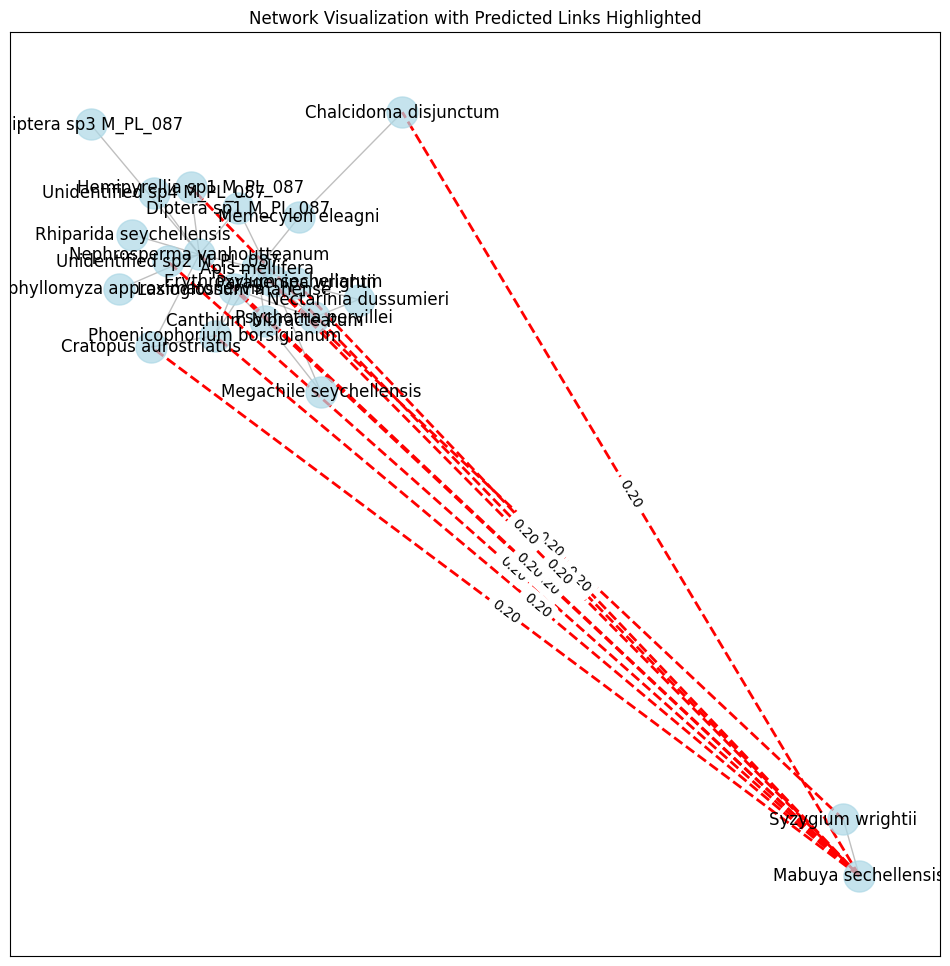

In [54]:
def visualize_network_with_predictions(G, predicted_edges, top_n=10):
    # Define node and edge colors
    node_color = 'lightblue'
    edge_color = 'gray'
    predicted_edge_color = 'red'

    # Extract the top N predicted edges
    top_predicted_edges = sorted(predicted_edges.items(), key=lambda x: x[1], reverse=True)[:top_n]
    top_predicted_edges_set = set([edge for edge, _ in top_predicted_edges])

    # Set up the plot
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G)  # Position nodes using the spring layout

    # Draw the nodes
    nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=500, alpha=0.7)
    nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

    # Draw the edges
    nx.draw_networkx_edges(G, pos, edgelist=[edge for edge in G.edges() if edge not in top_predicted_edges_set],
                           edge_color=edge_color, alpha=0.5)
    nx.draw_networkx_edges(G, pos, edgelist=top_predicted_edges_set,
                           edge_color=predicted_edge_color, width=2, style='dashed')

    # Draw edge labels with predicted probabilities
    edge_labels = {edge: f'{predicted_edges[edge]:.2f}' for edge in top_predicted_edges_set}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black')

    plt.title('Network Visualization with Predicted Links Highlighted')
    plt.show()

# Example usage
network = 'M_PL_061_04'
G = network_graphs[network]
predicted_edges = results[network]['top_predicted_links']
visualize_network_with_predictions(G, dict(predicted_edges))
